In [1]:
import torch
from sapiens.cnn import ResCNN, ResCNNConfig
from sapiens.utils import Dotdict
from sapiens.index import OntologyIndex, BuildConfig
import tomli
import json
from random import randint
from sapiens_api.utils import *
from sapiens_api.sapiens.stringops import SubstringExtractor

In [ ]:
config = ResCNNConfig(
    tokenizer = "michiyasunaga/BioLinkBERT-large",
    vocab_size =  28895,
    aggregate = "attentionpool",
    in_dim = 1024,
    block_dim = 256,
    out_dim = 256,
    dropout = 0.0,
    depth = 2
)
embedder = ResCNN(config)
embedder.load_ckpt("sapiens/resources/checkpoints/99d2852/run3/checkpoint_e4.pt")
embedder.eval()

In [3]:
import spacy
extractor = SubstringExtractor(spacy.load("en_ner_craft_md"))

In [4]:
GO_index = OntologyIndex(ontopath="sapiens/resources/ontologies/GO/go_BP_subset.json", distance_measure="cosine")
GO_index.load_index("sapiens/resources/index/index_cnn/")

In [100]:
c7 = json.load(open("sapiens/resources/msigdb/msigdb_C7.json", "r"))
i = randint(0, len(c7))
test_case = list(c7.keys())[i]
test_case = " ".join(test_case.lower().split("_")[1:-2])
test_case_desc =  c7[list(c7.keys())[i]]["DESCRIPTION_BRIEF"]
test_case_desc = preprocess(test_case_desc)
test_case_desc

'livers injected with IL6  SOCS3  knockout versus wildtype.'

In [111]:
txt_input = "change state cell organism result interleukin-6 stimulus"
embedding = embedder([txt_input]).detach().squeeze().numpy()
topk, distances = GO_index.search(embedding, 25)
topk

[GO:0010941|regulation of cell death,
 GO:0002819|regulation of adaptive immune response,
 GO:0002920|regulation of humoral immune response,
 GO:0050776|regulation of immune response,
 GO:0031347|regulation of defense response,
 GO:1905677|regulation of adaptive immune effector response,
 GO:0051128|regulation of cell organization,
 GO:0065007|regulation,
 GO:0060330|regulation of response to immune interferon,
 GO:0070232|regulation of T cell apoptosis,
 GO:0001776|immune cell homeostasis,
 GO:0019725|cellular homeostasis,
 GO:0002834|regulation of response to tumor cell,
 GO:2000269|regulation of fibroblast apoptosis,
 GO:1905679|up regulation of adaptive immune effector response,
 GO:0042981|regulation of apoptosis,
 GO:0061519|macrophage homeostasis,
 GO:1905679|positive regulation of adaptive immune effector response,
 GO:0042592|regulation of homeostatic process,
 GO:0042592|homeostasis,
 GO:0002821|up regulation of adaptive immune response,
 GO:0002922|up regulation of humoral i

In [65]:
rerank(test_case_desc, topk, 5)

([GO:1903980|activation of microglial cell activation,
  GO:1902565|activation of neutrophil activation,
  GO:0045917|activation of complement activation,
  GO:0050870|activation of T cell activation,
  GO:0050871|activation of B cell activation],
 [35, 34, 34, 33, 33])

### Model debugging

Here we look at the attention weights for each token in the signature description

In [18]:
X = embedder.bert_base([test_case_desc])
X2 = torch.zeros(size=X.shape)
test = embedder.debug(X)
test_base = embedder.debug(torch.zeros(size=X2.shape))
toks = embedder.bert_base([test_case_desc],return_option="toks_only").tokens()

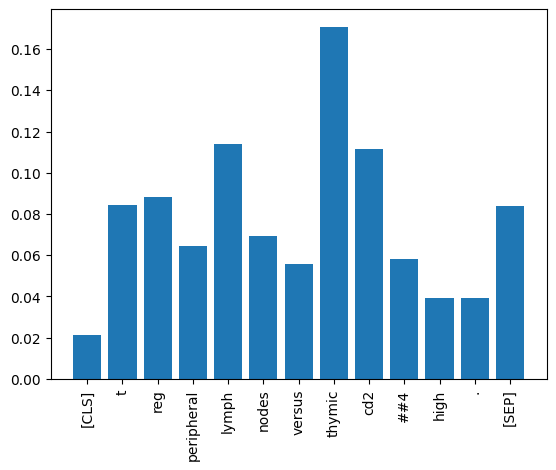

In [19]:
import matplotlib.pyplot as plt

def attn(X):
    return torch.nn.functional.softmax(embedder.agg.Q(X.mT), dim=1).flatten()

sums = torch.abs(attn(test[1])).detach()
plt.bar(range(len(toks)), sums)
plt.xticks(range(len(toks)), labels=toks, rotation = 90)
plt.show()